In [22]:
# 设置Python
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

In [23]:
# 加载caffe
# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
caffe_root = '../'  # this file should be run from {caffe_root}/examples (otherwise change this line)
sys.path.insert(0, caffe_root + 'python')

import caffe
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

In [24]:
# 如果需要，则下载相关的model
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


In [25]:
# 设置CPU模式，并加载从磁盘中加载net
caffe.set_mode_cpu()

model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def,      # defines the structure of the model
                model_weights,  # contains the trained weights
                caffe.TEST)     # use test mode (e.g., don't perform dropout)

In [26]:
# load the mean ImageNet image (as distributed with Caffe) for subtraction
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
#print mu
mu = mu.mean(1).mean(1)  # average over pixels to obtain the mean (BGR) pixel values
print 'mean-subtracted values:', zip('BGR', mu)

# create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

transformer.set_transpose('data', (2,0,1))  # move image channels to outermost dimension
transformer.set_mean('data', mu)            # subtract the dataset-mean value in each channel
transformer.set_raw_scale('data', 255)      # rescale from [0, 1] to [0, 255]
transformer.set_channel_swap('data', (2,1,0))  # swap channels from RGB to BGR

mean-subtracted values: [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [27]:
# set the size of the input (we can skip this if we're happy
#  with the default; we can also change it later, e.g., for different batch sizes)
net.blobs['data'].reshape(50,        # batch size
                          3,         # 3-channel (BGR) images
                          227, 227)  # image size is 227x227

image.shape: (360, 480, 3)
transformed_image.shape: (3, 227, 227)


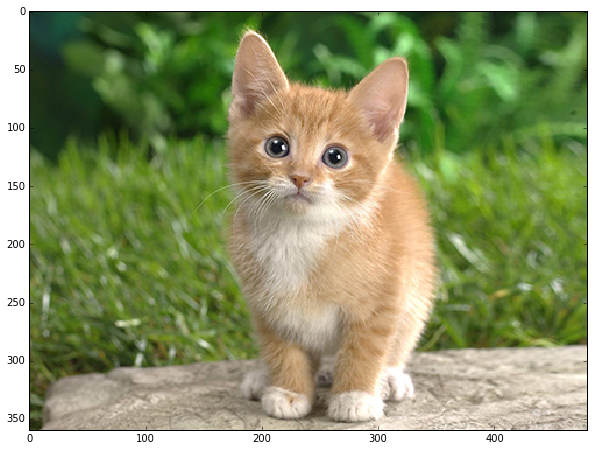

In [28]:
# 加载一张图片，并执行前面的设置
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)
print 'image.shape:', image.shape
# print image*255 # 原始图片的数据
print 'transformed_image.shape:', transformed_image.shape
# print transformed_image # 经过缩放，消除均值等变化后的图片的数据

In [29]:
# 分类
# copy the image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

### perform classification 执行一次前向计算， 输出prob_，即属于每个类的概率的向量
output = net.forward()
output_prob = output['prob'][0]  # the output probability vector for the first image in the batch

print 'predicted class is:', output_prob.argmax()

predicted class is: 281


In [30]:
# 检查分类是否正确
# load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')

print('共分类了%d图片,每张图片输出了%d个预测结果: '%(output['prob'].size//output['prob'][0].size, output['prob'][0].size))
print 'output label:', labels[output_prob.argmax()]

共分类了50图片,每张图片输出了1000个预测结果: 
output label: n02123045 tabby, tabby cat


In [31]:
# 打印top-5
# sort top five predictions from softmax output
print '前5个类别', output_prob.argsort()[::-1][:5]
top_inds = output_prob.argsort()[::-1][:5]  # reverse sort and take five largest items

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])

前5个类别 [281 282 285 277 287]
probabilities and labels:


[(0.31243595, 'n02123045 tabby, tabby cat'),
 (0.23797044, 'n02123159 tiger cat'),
 (0.12387222, 'n02124075 Egyptian cat'),
 (0.10075735, 'n02119022 red fox, Vulpes vulpes'),
 (0.070957191, 'n02127052 lynx, catamount')]

In [11]:
# 测试CPU下的用时
%timeit net.forward()

1 loop, best of 3: 7.61 s per loop


In [12]:
# 测试GPU下的用时
caffe.set_device(3)  # if we have multiple GPUs, pick the first one
caffe.set_mode_gpu()
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 111 ms per loop


In [13]:
# 打印各层的非学习参数(激活值)的shape
# for each layer, show the output shape
print 'layer_name\tdata_shape'
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

layer_name	data_shape
data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [14]:
# 打印各层的可学习参数: 权重和偏置值
print 'layer_name\tweight_shape\tbias_shape'
for layer_name, param in net.params.iteritems():
    print layer_name + '\t' + str(param[0].data.shape), str(param[1].data.shape)

layer_name	weight_shape	bias_shape
conv1	(96, 3, 11, 11) (96,)
conv2	(256, 48, 5, 5) (256,)
conv3	(384, 256, 3, 3) (384,)
conv4	(384, 192, 3, 3) (384,)
conv5	(256, 192, 3, 3) (256,)
fc6	(4096, 9216) (4096,)
fc7	(4096, 4096) (4096,)
fc8	(1000, 4096) (1000,)


In [15]:
# 定义一个帮助函数来处理四维的数据的可视化
def vis_square(data, layer_name):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    print layer_name
    plt.imshow(data); plt.axis('off')

(64, 3, 11, 11)
conv1
(48, 5, 5)
conv2


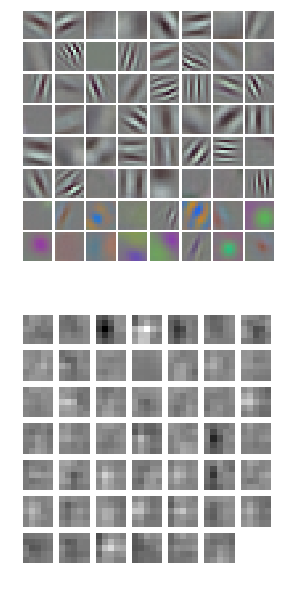

In [16]:
# 可视化各层的可学习参数
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data[0:64]
print filters.shape
plt.subplot(2,1,1)
vis_square(filters.transpose(0, 2, 3, 1), 'conv1')

# 第二个卷积层的可视化
filters2 = net.params['conv2'][0].data[0,:,:,:] # 因其shape为(256，48, 5, 5)，所以不能是彩色
print filters2.shape
plt.subplot(2,1,2)
vis_square(filters2, 'conv2')


(60, 55, 55)
conv1


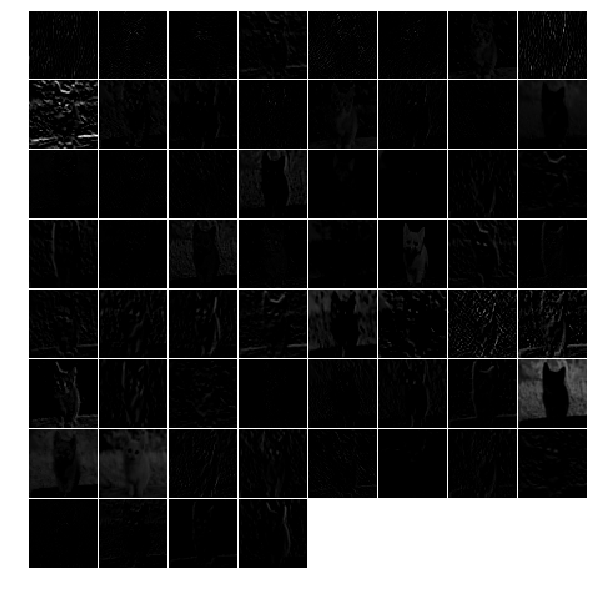

In [17]:
# 图像经过第一次卷积后的输出
feat = net.blobs['conv1'].data[0, 36:]
print feat.shape
vis_square(feat, 'conv1')

(256, 6, 6)
pool5


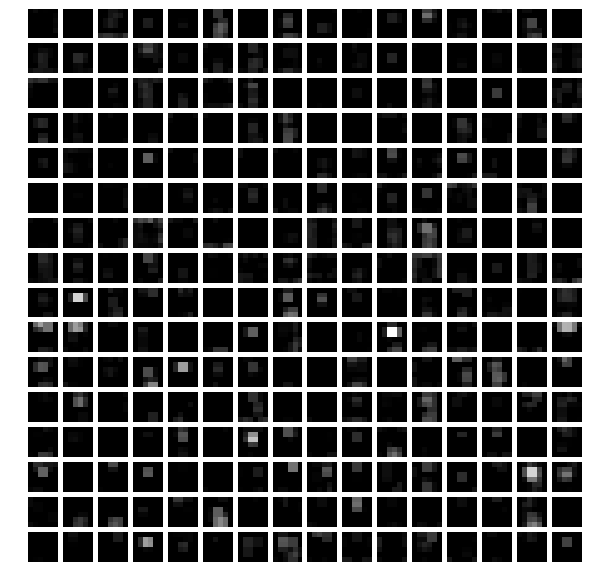

In [18]:
# 采样后的第5层的输出
feat = net.blobs['pool5'].data[0]
print feat.shape
vis_square(feat, 'pool5')

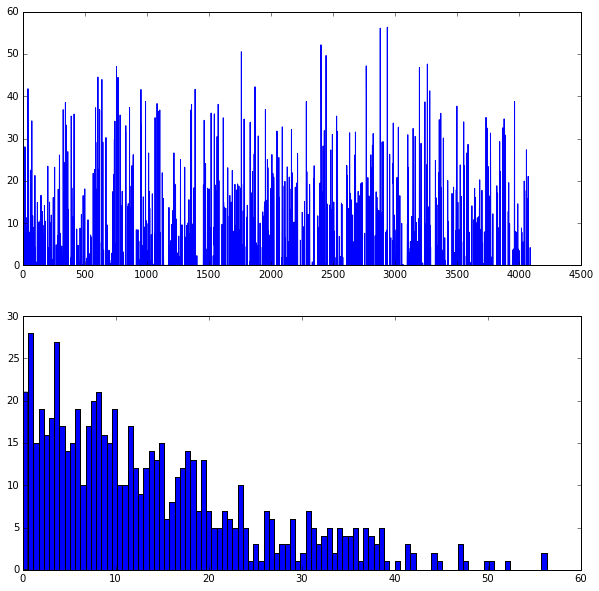

In [19]:
# 第一个经过ReLU处理的全链接层，展示其输出和正值的直方图
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
#print feat[0:100]
plt.plot(feat.flat) # 迭代打印
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100) # 

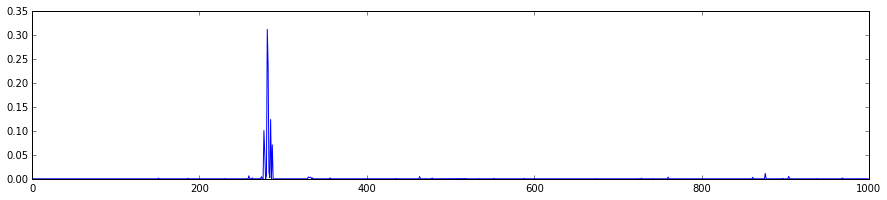

In [20]:
# 最后分类概率的输出
feat = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 3))
plt.plot(feat.flat)

--2016-04-22 09:14:27--  http://pic36.nipic.com/20131225/15361977_173809448168_2.jpg
正在解析主机 pic36.nipic.com... 36.250.87.33, 36.250.87.32, 222.163.201.54, ...
正在连接 pic36.nipic.com|36.250.87.33|:80... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：106393 (104K) [image/jpeg]
正在保存至: “image.jpg”

100%[======================================>] 106,393     --.-K/s   in 0.1s    

2016-04-22 09:14:27 (851 KB/s) - 已保存 “image.jpg” [106393/106393])

probabilities and labels:


[(0.98531926, 'n02690373 airliner'),
 (0.012345654, 'n04592741 wing'),
 (0.0017366442, 'n04266014 space shuttle'),
 (0.00039643203, 'n04552348 warplane, military plane'),
 (0.00013501615, 'n04008634 projectile, missile')]

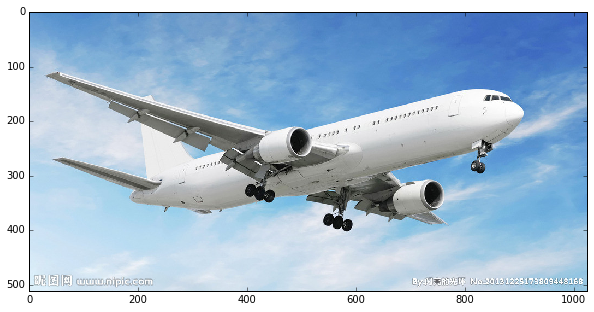

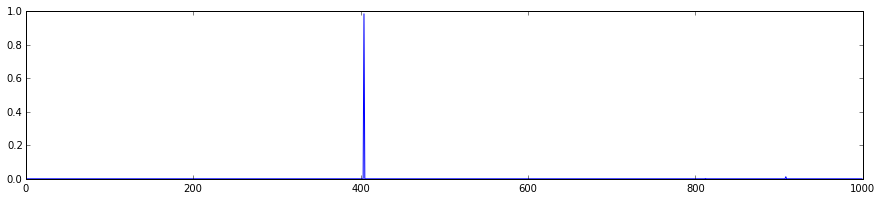

In [21]:
# 对任意图片进行分类
# download an image
my_image_url = "http://pic36.nipic.com/20131225/15361977_173809448168_2.jpg"  # paste your URL here
#my_image_url = "http://pic3.newssc.org/upload/news/20130520/1369041244331.jpg"
# for example:
# my_image_url = "https://upload.wikimedia.org/wikipedia/commons/b/be/Orang_Utan%2C_Semenggok_Forest_Reserve%2C_Sarawak%2C_Borneo%2C_Malaysia.JPG"
!wget -O image.jpg $my_image_url

# transform it and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# perform classification
net.forward()

# obtain the output probabilities
output_prob = net.blobs['prob'].data[0]

# sort top five predictions from softmax output
top_inds = output_prob.argsort()[::-1][:5]

plt.imshow(image)

plt.figure(figsize=(15, 3))
plt.plot(output_prob.flat)

print 'probabilities and labels:'
zip(output_prob[top_inds], labels[top_inds])